In [1]:
import mmcv
from mmcv import Config
from mmdet.datasets import (build_dataloader, build_dataset,
                            replace_ImageToTensor)
from mmdet.models import build_detector
from mmdet.apis import single_gpu_test, inference_detector, init_detector, show_result_pyplot
from mmcv.runner import load_checkpoint
import os
from mmcv.parallel import MMDataParallel
import matplotlib.pyplot as plt 
import pandas as pd
from pandas import DataFrame
from pycocotools.coco import COCO
import numpy as np
import cv2

/opt/conda/envs/detection/lib/python3.7/site-packages/mmcv/__init__.py:21: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  'On January 1, 2023, MMCV will release v2.0.0, in which it will remove '


In [5]:
classes = ("General trash", "Paper", "Paper pack", "Metal", "Glass", 
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing")

# config file 들고오기
cfg = Config.fromfile('./configs/_cascade_swin_batch8/final_cascade_swin.py')

root='../../dataset/'
epoch = 'latest'
cfg.work_dir = './work_dirs/_cascade_swin_batch8'

cfg.model.train_cfg = None

In [6]:
# build dataset & dataloader

dataset = build_dataset(cfg.data.test)
data_loader = build_dataloader(
        dataset,
        samples_per_gpu=1,
        workers_per_gpu=cfg.data.workers_per_gpu,
        dist=False,
        shuffle=False)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [7]:
checkpoint = os.path.join(cfg.work_dir, f'{epoch}.pth')

device='cuda:0'
cfg.model.pretrained = None

# Initialize the detector
model = build_detector(cfg.model)

# Load checkpoint
checkpoint = load_checkpoint(model, checkpoint, map_location=device)
model.CLASSES = dataset.CLASSES

model.cfg = cfg
model.to(device)
model.eval()

load checkpoint from local path: ./work_dirs/_cascade_swin_batch8/latest.pth


CascadeRCNN(
  (backbone): SwinTransformer(
    (patch_embed): PatchEmbed(
      (adap_padding): AdaptivePadding()
      (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (drop_after_pos): Dropout(p=0.0, inplace=False)
    (stages): ModuleList(
      (0): SwinBlockSequence(
        (blocks): ModuleList(
          (0): SwinBlock(
            (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
            (attn): ShiftWindowMSA(
              (w_msa): WindowMSA(
                (qkv): Linear(in_features=96, out_features=288, bias=True)
                (attn_drop): Dropout(p=0.0, inplace=False)
                (proj): Linear(in_features=96, out_features=96, bias=True)
                (proj_drop): Dropout(p=0.0, inplace=False)
                (softmax): Softmax(dim=-1)
              )
              (drop): DropPath()
            )
            (norm2): LayerNorm((96,), eps=1e-05, elementwise_

In [8]:
# coco = COCO('../dataset/train.json')
coco = COCO('../../dataset/val_data_fold_3_seed_411.json')
df = pd.DataFrame()
image_ids = []
class_name = []
class_id = []
x_min = []
y_min = []
x_max = []
y_max = []
classes = ["General trash", "Paper", "Paper pack", "Metal", "Glass", "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]

for image_id in coco.getImgIds():
    imageinfo = coco.loadImgs(image_id)[0]
    annids = coco.getAnnIds(imgIds=imageinfo['id'])
    anns = coco.loadAnns(annids)
    filename = imageinfo['file_name']

    for ann in anns:
        image_ids.append(filename)
        class_name.append(classes[ann['category_id']])
        class_id.append(ann['category_id'])
        x_min.append(float(ann['bbox'][0]))
        y_min.append(float(ann['bbox'][1]))
        x_max.append(float(ann['bbox'][0]) + float(ann['bbox'][2]))
        y_max.append(float(ann['bbox'][1]) + float(ann['bbox'][3]))

df['image_id'] = image_ids
df['classname'] = class_name
df['category_id'] = class_id
df['xmin'] = x_min
df['ymin'] = y_min
df['xmax'] = x_max
df['ymax'] = y_max

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


KeyboardInterrupt: 

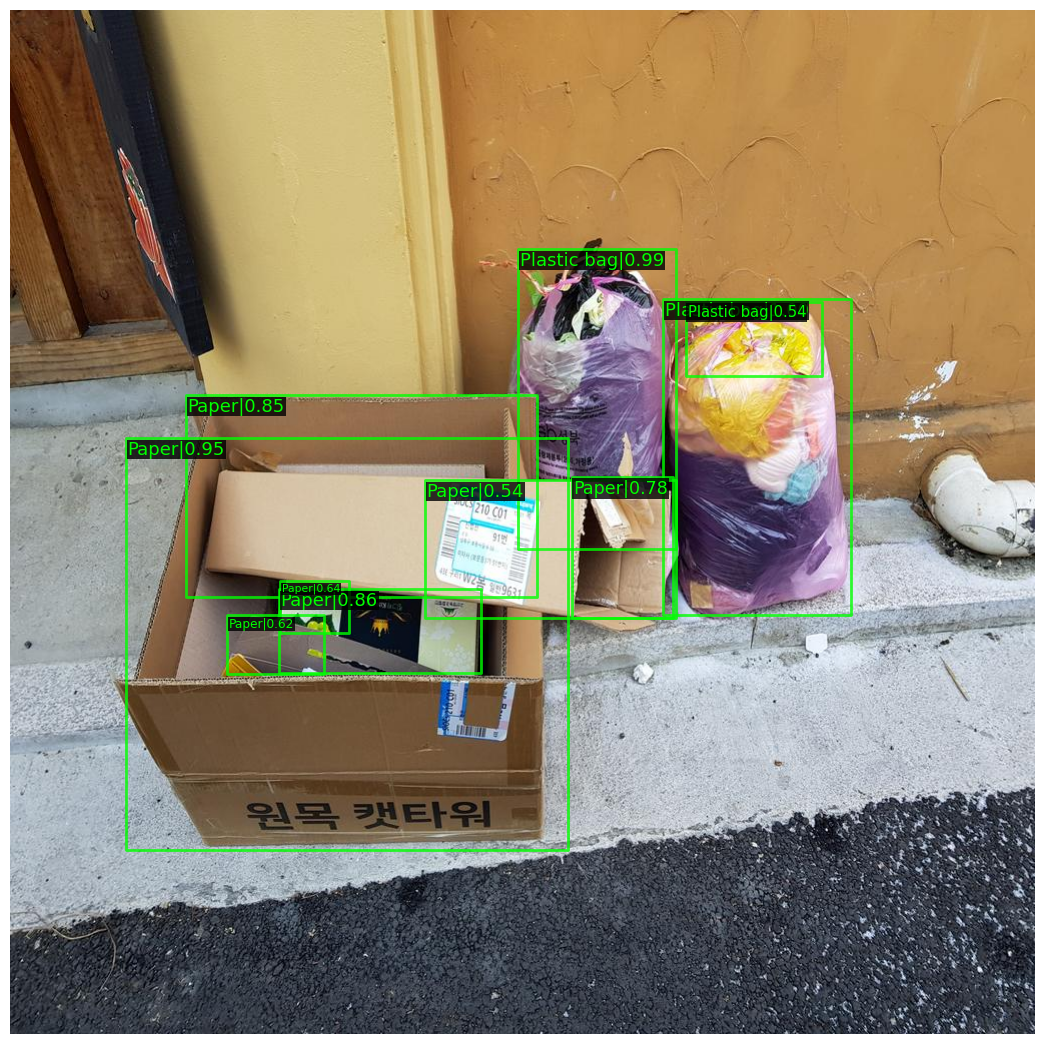

In [10]:
## 이미지 test & test 결과 이미지 저장
from matplotlib.patches import Rectangle
from PIL import Image
from mmdet.core.bbox import bbox_overlaps
import torch
import torchvision.ops.boxes as bops

data_dir = '../../dataset/' 

success_path = f'{cfg.work_dir}/vis_success'
fail_path = f'{cfg.work_dir}/vis_fail'

os.makedirs(os.path.join(success_path, 'train'), exist_ok=True)
os.makedirs(os.path.join(fail_path, 'train'), exist_ok=True)

n = 0
for image_id in coco.getImgIds():
    plt.clf()
    imageinfo = coco.loadImgs(image_id)[0]
    annids = coco.getAnnIds(imgIds=imageinfo['id'])
    anns = coco.loadAnns(annids)
    filename = imageinfo['file_name']

    # 이미지 경로 가져오기
    img_info = coco.loadImgs(image_id)[0]
    img_path = os.path.join(data_dir, filename)

    img = mmcv.imread(f'{img_path}')

    result = inference_detector(model, img)

    has_wholeTP_predbox = True
    # 박스 그리기 조건 검사
    for ann in anns:
        gt_bbox = ann['bbox']
        gt_class_id = ann['category_id']
        x, y, w, h = gt_bbox
        gt_bbox_ = [x, y, x+w, y+h]
        is_TP = False
        for pred_bbox in result[gt_class_id]:
            box1 = torch.tensor(np.array([gt_bbox_]), dtype=torch.float)
            box2 = torch.tensor(np.array([pred_bbox])[:, :-1], dtype=torch.float)
            
            iou = bops.box_iou(box1, box2)

            ## 클래스도 동일하고, iou가 0.5 이상일경우
            if iou >= 0.5:
                is_TP = True
                break
        if not is_TP : 
            has_wholeTP_predbox = False
            break
    
    # 이미지 저장
    if not has_wholeTP_predbox:
        result_img = model.show_result(
            img,
            result,
            score_thr=0.5,
            bbox_color='green',
            text_color='green',
            thickness=2,
            font_size=13,
            out_file= f'{fail_path}/{filename}'
        )
        img_pred = mmcv.imread(f'{fail_path}/{filename}')
    
    else : 
        result_img = model.show_result(
            img,
            result,
            score_thr=0.5,
            bbox_color='green',
            text_color='green',
            thickness=2,
            font_size=13,
            out_file= f'{success_path}/{filename}'
        )
        img_pred = mmcv.imread(f'{success_path}/{filename}')

    for ann in anns:
        gt_bbox = ann['bbox']
        gt_class_id = ann['category_id']
        bbox = np.array(gt_bbox).astype(np.int32)
        
        cv2.rectangle(img_pred, (bbox[0], bbox[1]), (bbox[0] + bbox[2], bbox[1] + bbox[3]), (0, 0, 255), 2)
        cv2.putText(img_pred, dataset.CLASSES[gt_class_id], (bbox[0], bbox[1]), cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.8, color=(0,0, 255), thickness=2)

    img = cv2.cvtColor(img_pred,cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10,10))

    if not has_wholeTP_predbox:
        save_path = os.path.join(fail_path, f'{filename}')
        plt.imsave(save_path,img)
    else : 
        save_path = os.path.join(success_path, f'{filename}')
        plt.imsave(save_path,img)